In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt
import matplotlib.animation as animation
import IPython.display as display
from skimage.draw import circle_perimeter, disk
import skvideo.io
import skvideo.datasets

%matplotlib inline
sns.set_context("paper")

In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
vid_folder = "/Users/loaner/Documents/GitHub/bite-tracks/sample_leg_2/"
plot_folder = "/Users/loaner/Documents/GitHub/bite-tracks/plots/"

In [4]:
vid = 'video2/'

In [5]:
filename = "midleg_1DLC_resnet50_midleg_deetMay17shuffle1_500000.csv"

In [6]:
legDf = pd.read_csv(vid_folder+vid+filename,header=[1,2],index_col=0)

In [7]:
fps = 30

## Masking

In [8]:
likeLthresh = 0.65

In [9]:
mask = (sp.ndimage.gaussian_filter(legDf['Org']['likelihood'],10)>
        likeLthresh)

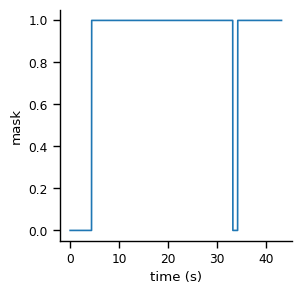

In [10]:
plt.figure(figsize = (3,3))
plt.plot(np.arange(len(mask))/fps, mask);
plt.ylabel("mask")
plt.xlabel("time (s)")
sns.despine();

In [11]:
fr = np.arange(np.sum(mask)) #masked frames
time = fr/fps

## Estimate Radius and Center

In [12]:
def rad_est(points):
    #Thomas and Chan 1988
    
    N = len(points)
    
    sigX2 = np.sum(points[:,0]**2)
    sigY2 = np.sum(points[:,1]**2)
    sigX = np.sum(points[:,0])
    sigY = np.sum(points[:,1])
    sigXY = np.sum(points[:,0]*points[:,1])
    sigX3 = np.sum(points[:,0]**3)
    sigY3 = np.sum(points[:,1]**3)
    sigXY2 = np.sum(points[:,0]*(points[:,1]**2))
    sigX2Y = np.sum(points[:,1]*(points[:,0]**2))
    
    a1 = 2*((sigX**2) - N*sigX2)
    a2 = 2*(sigX*sigY - N*sigXY)
    b1 = a2
    b2 = 2*((sigY**2) - N*sigY2)
    c1 = sigX2*sigX - N*sigX3 + sigX*sigY2 - N*sigXY2
    c2 = sigX2*sigY - N*sigY3 + sigY*sigY2 - N*sigX2Y
    
    xbar = (c1*b2 - c2*b1)/(a1*b2-a2*b1)
    ybar = (a1*c2 - a2*c1)/(a1*b2-a2*b1)
    
    r = np.sqrt(1/N*(sigX2 - 2*sigX*xbar + N*(xbar**2) + sigY2 - 2*sigY*ybar + N*(ybar**2)))
    
    return r, xbar, ybar

In [13]:
n_circ_points = 9

In [14]:
circ_points = np.array([legDf['ci'+str(i)].iloc[mask,:2].values for i in range(1,n_circ_points+1)])

In [15]:
r = np.zeros(circ_points.shape[1])
orgs = np.zeros([circ_points.shape[1],2])
for f in range(circ_points.shape[1]):
    r[f],orgs[f,0],orgs[f,1] = rad_est(circ_points[:,f,:])

## Estimate Bound

Estimate noise power

In [16]:
noiseP = np.sum(np.cov(orgs[:,0],orgs[:,1]))

In [17]:
def CRLB(points, r, xbar, ybar, noiseP):
    dX = points[:,0]-xbar
    dY = points[:,1]-ybar
    f11 = 1/(r**4)*np.sum(dX**4 + (dY**2)*(dX**2))
    f12 = 1/(r**4)*np.sum((dX**3)*dY + (dY**3)*dX)
    f13 = 1/(r**3)*np.sum((dX**3) + (dY**2)*dX)
    f22 = 1/(r**4)*np.sum((dY**2)*(dX**2) + dY**4)
    f23 = 1/(r**3)*np.sum(dY*(dX**2) + dY**3)
    f33 = 1/(r**2)*np.sum((dX**2) + (dY**2))
    FIM = (1/noiseP)*np.array([[f11, f12, f13], [f12, f22, f23], [f13, f23, f33]])
    A = np.linalg.inv(FIM)
    rCRLB = A[2,2]
    xCRLB = A[0,0]
    yCRLB = A[1,1]
    return rCRLB,xCRLB,yCRLB

In [18]:
rCRLB = np.zeros(circ_points.shape[1])
xCRLB = np.zeros(circ_points.shape[1])
yCRLB = np.zeros(circ_points.shape[1])
for f in range(circ_points.shape[1]):
    rCRLB[f],xCRLB[f],yCRLB[f] = CRLB(circ_points[:,f,:], r[f], orgs[f,0], orgs[f,1], noiseP)

## Foot Distance From Origin

In [19]:
timelim = [5,25] #as a fraction
time_mask = (time>timelim[0]) & (time<timelim[1])

In [20]:
timepoints = [8, 14, 17] #as a fraction

In [21]:
dFtXY = legDf['tar1'].iloc[mask,:2].values-orgs
dFt = np.sqrt(np.sum(dFtXY**2,axis=1))

In [22]:
#smoothing
sdFt = sp.ndimage.gaussian_filter(dFt,1)
sR = sp.ndimage.gaussian_filter(r,1)
s_sqrt_RCRLB = sp.ndimage.gaussian_filter(np.sqrt(rCRLB),1)
s_sqrt_OCRLB = sp.ndimage.gaussian_filter(np.sqrt(((dFtXY[:,0]/dFt)**2)*xCRLB+((dFtXY[:,1]/dFt)**2)*yCRLB),1)

In [23]:
rel_time = False

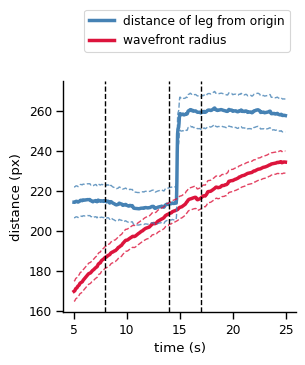

In [24]:
plt.figure(figsize = (3,3))
plt.plot(time[time_mask], sdFt[time_mask],'-',color='steelblue',linewidth=2.5,alpha=1);

plt.plot(time[time_mask], sR[time_mask],'-',color='crimson',linewidth=2.5,alpha=1);
plt.plot(time[time_mask], sdFt[time_mask]-s_sqrt_OCRLB[time_mask],'--',color='steelblue',linewidth=1,alpha=0.8);
plt.plot(time[time_mask], sdFt[time_mask]+s_sqrt_OCRLB[time_mask],'--',color='steelblue',linewidth=1,alpha=0.8);
plt.plot(time[time_mask], sR[time_mask]+s_sqrt_RCRLB[time_mask],'--',color='crimson',linewidth=1,alpha=0.8);
plt.plot(time[time_mask], sR[time_mask]-s_sqrt_RCRLB[time_mask],'--',color='crimson',linewidth=1,alpha=0.8);

for t in timepoints:
    plt.axvline(t,color='k',linestyle='--',linewidth=1)

plt.legend(['distance of leg from origin','wavefront radius'],loc='lower right',bbox_to_anchor = (1,1.1));
plt.xlabel("time (s)")
plt.ylabel("distance (px)")
sns.despine()

if rel_time:
    trel = time[time_mask] - np.min(time[time_mask])
    plt.xticks(time[time_mask][::int(len(trel)/5)],labels=["%.0f" % number 
            for number in np.round(trel[::int(len(trel)/5)])])

plt.savefig(plot_folder+"leg-wavefront-crossing.pdf",bbox_inches = "tight")

In [25]:
dist_to_front = sdFt - sR

In [26]:
s_sqrt_DCRLB = np.sqrt(s_sqrt_RCRLB**2 + s_sqrt_OCRLB**2)

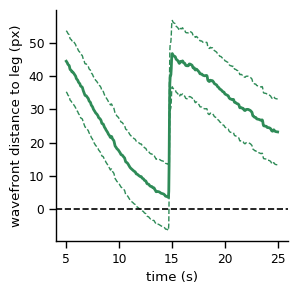

In [27]:
plt.figure(figsize = (3,3))
plt.plot(time[time_mask],dist_to_front[time_mask],'-',color='seagreen',linewidth=2);
plt.plot(time[time_mask],dist_to_front[time_mask]-s_sqrt_DCRLB[time_mask],'--',color='seagreen',linewidth=1);
plt.plot(time[time_mask],dist_to_front[time_mask]+s_sqrt_DCRLB[time_mask],'--',color='seagreen',linewidth=1);
plt.axhline(0,linestyle='--',color='k');
plt.xlabel("time (s)")
plt.ylabel("wavefront distance to leg (px)")
sns.despine()

if rel_time:
    trel = time[time_mask] - np.min(time[time_mask])
    plt.xticks(time[time_mask][::int(len(trel)/5)],labels=["%.0f" % number 
            for number in np.round(trel[::int(len(trel)/5)])])

plt.savefig(plot_folder+"leg-wavefront-distance.pdf",bbox_inches = "tight")

## Modeling as Diffusion

In [28]:
prop = 0.3
growth = r[:int(len(r)*prop)]

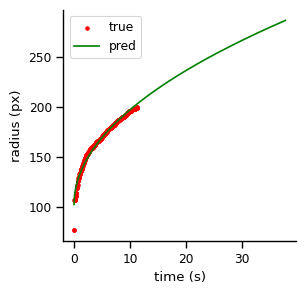

In [29]:
from scipy.optimize import curve_fit

def func(t,a,b):
    return a*((t)**(1/2))+b

t_meas = np.arange(len(growth))/fps
t_full = np.arange(np.sum(mask))/fps

popt, pcov = curve_fit(func,t_meas,growth)
growth_fit = func(t_full,*popt)

fig,ax = plt.subplots(figsize= (3,3))
ax.scatter(t_meas,growth,c='r',label='true',s=6)
ax.plot(t_full,growth_fit,c='g',label='pred')
ax.legend(loc='best');
plt.xlabel("time (s)")
plt.ylabel("radius (px)");
sns.despine()

## Video Analysis

In [30]:
video = skvideo.io.vread(vid_folder+vid+filename.replace(".csv","_labeled.mp4"))

In [31]:
clipped_vid = video[mask,:,:,:]

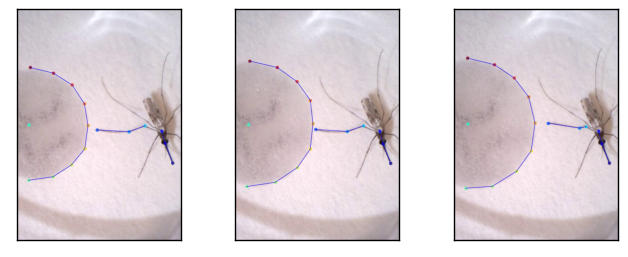

In [32]:
fig, ax = plt.subplots(1,len(timepoints),figsize = (8,3));
for i,t in enumerate(timepoints):
    ax[i].imshow(clipped_vid[int(t*fps),
                int(orgs.mean(axis=0)[1]-clipped_vid.shape[2]/5):int(orgs.mean(axis=0)[1]+clipped_vid.shape[2]/5),
                int(orgs.mean(axis=0)[0]-clipped_vid.shape[1]/20):int(orgs.mean(axis=0)[0]+clipped_vid.shape[1]/2.2)])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.savefig(plot_folder+"snapshots.pdf",bbox_inches = "tight",dpi=300)

In [33]:
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios': [4, 1]},figsize = (7,7))

im = ax1.imshow(video[0,:,:], cmap='gray',origin='upper')
line1, = ax2.plot(fr, sdFt, color='steelblue', linewidth=2)
line2, = ax2.plot(fr, sR, color='crimson', linewidth=2)

line11, = ax2.plot(fr, sdFt-s_sqrt_OCRLB, '--',color='steelblue', linewidth=1,alpha=0.8)
line12, = ax2.plot(fr, sdFt+s_sqrt_OCRLB, '--',color='steelblue', linewidth=1,alpha=0.8)
line21, = ax2.plot(fr, sR+s_sqrt_RCRLB, '--', color='crimson', linewidth=1,alpha=0.8)
line22, = ax2.plot(fr, sR-s_sqrt_OCRLB, '--', color='crimson', linewidth=1,alpha=0.8)

ax1.axis('off')
ax2.axis('off')
plt.legend(['distance of leg from origin', 'wavefront radius'],
           loc='upper left',fontsize=12, bbox_to_anchor = (0,1.5));
plt.tight_layout(pad=1)

def animate(i):
    
    #draw outer border
    rr, cc = circle_perimeter(int(orgs[i,1]), int(orgs[i,0]), int(sR[i]+s_sqrt_RCRLB[i]))
    clipped_vid[i,rr,cc] = [255,0,0]
    
    #draw inner border
    rr, cc = circle_perimeter(int(orgs[i,1]), int(orgs[i,0]), int(sR[i]-s_sqrt_RCRLB[i]))
    clipped_vid[i,rr,cc] = [255,0,0]
    
    im.set_array(clipped_vid[i,:,:])
    
    line1.set_xdata(fr[:i])
    line1.set_ydata(sdFt[:i]) 

    line2.set_xdata(fr[:i])
    line2.set_ydata(sR[:i]) 
    
    line11.set_xdata(fr[:i])
    line11.set_ydata(sdFt[:i]-s_sqrt_OCRLB[:i]) 
    
    line12.set_xdata(fr[:i])
    line12.set_ydata(sdFt[:i]+s_sqrt_OCRLB[:i])
    
    line21.set_xdata(fr[:i])
    line21.set_ydata(sR[:i]-s_sqrt_RCRLB[:i])
    
    line22.set_xdata(fr[:i])
    line22.set_ydata(sR[:i]+s_sqrt_RCRLB[:i]) # update the data.
    return [im, line1]

ani = animation.FuncAnimation(
    fig, animate, interval=1000/fps, frames = range(np.sum(mask)))

v = ani.to_html5_video()
html = display.HTML(v)
display.display(html)
plt.close()
ani.save(plot_folder+'leg-wavefront-crossing.mp4', fps=fps, dpi=300, extra_args=['-vcodec', 'libx264'])